# Part 1: Predicting 1D values with Gaussian Processes
This notebook shall show, how to implement a simple Gaussian Process. As with many of my notebooks, I will not try to elaborately explain what a Gaussian Process is, but rather try to provide good copy and paste code to quickly implement it your purpose. A Gaussian Process or GP is a so called **non-parametric** bayesian inference method to approximate a function. They are non-parametric as you don't need to specify a mean or covariance (if you don't want to). They are very commonly used for time-series predictions as they can come quite close to a function with very little data points available. Also, we can show our uncertainty around the prediction which is great! 

If you want to learn more about these models try checking out these resources: 
- [https://distill.pub/2019/visual-exploration-gaussian-processes/](Fairly elaborate and visual explaination. Although a bit math heavy.)
- [https://katbailey.github.io/post/gaussian-processes-for-dummies/](Very accessible introduction with some code examples)


So without further ado! Let's dive in.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import itertools
from scipy import stats

## Defining some initial functions to generate random data. 
The gaussian process shall simulate the function based on a small data sample. The plot shows the generation of random data with a sigmoid as latent function. This sigmoid is the function we want to learn.

I chose a scaled sigmoid function and shifted it downwards. Now, the sigmoid will remain within the range of -1 and 1. This is important as the Gaussian process typically assumes a mean of zero for the data. This can easily be done via standardization. I don't say it won't work without standardization but it is definitely desirable. For more on that checkout this need explanation on [https://stats.stackexchange.com/a/179039](StackOverflow). 

In [72]:
def sigmoid(x):
    return 2*((1 / (1 + np.exp(-x))) - .5)

def sinusoidal(x):
    return np.sin(x) * 1

def generate_data(num, func):
    time_points = np.sort(np.random.uniform(-5,5,num))
    noise = np.random.normal(0, .1,size=num)
    data_points = func(time_points)  + noise
    return pd.DataFrame(zip(time_points, data_points) , columns=["time", "values"])

def generate_data_multiple_x(num, functions):
    result = pd.DataFrame(np.ones(100), columns=["values"])
    for idx, func in enumerate(functions):
        data = generate_data(num, func)
        result[f"time_{idx}"] = data["time"]
        result[f"values"] *= data["values"] 
    return result

def generate_data_multivariat_gaussian(num):
    X = np.random.normal(size=num)
    Y = np.random.normal(size=num)
    mu = np.array([0, 0])
    cov = np.array([[.5, .2],[.2, .5]])
    rv = stats.multivariate_normal(mu, cov)
    pos = np.dstack((X, Y))
    Z = rv.pdf(pos)
    return pd.DataFrame(np.dstack((X,Y,Z))[0], columns=["time_0", "time_1", "values"])

This visualizes a noisy distribution around the function. In blue we see the true function. Red shows noisy observed values $y$ for the training $x$. The green dashlines are the positions $x_*$ whose values $y_*$ we want to predict .



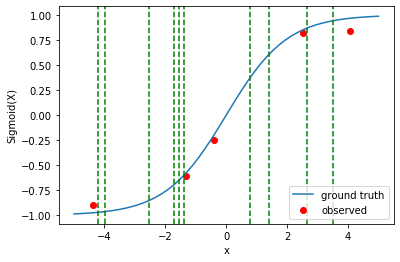

In [128]:
data = generate_data(100, sigmoid)
x_ = np.linspace(-5,5)
gtruth = sigmoid(x_)
observed = data.sample(5).sort_values(by="time")
unobserved = data["time"].sample(10).sort_values()
plt.plot(x_, gtruth, label="ground truth") 
plt.scatter(observed["time"], observed["values"], c="red", label="observed")
for idx, xc in enumerate(unobserved.values):
    plt.axvline(x=xc, linestyle='dashed', c="green")
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  
plt.legend() 
plt.show() 

# Prediction with 1-dimensional X and 1-dimensional Y

Methods implements kernel function and covariance construction according to equations below.

\begin{align}
    k(x, y) &= \exp\left( - \frac{1}{2 \sigma^2} \lVert x - y \rVert^2 \right) &
    K &= \begin{bmatrix}
    k(x_1,x_1)&\cdots &k(x_n,x_1) \\
    \vdots & \ddots & \vdots\\
    k(x_1,x_n)&\cdots &k(x_n,x_n)
    \end{bmatrix} &
    K_* &= [k(x_*,x_1), \cdots, k(x_*,x_n)] &
    K_{**} &= [k(x_*, x_*)]
\end{align}

This is the implementation of the Gaussian kernel. It is not complete, as I omitted several hyperparameters but it should be trivial to read other resources and extend it as required. The first method is the Gaussian RBF kernel $k(x,y)$ in a vectorized form. The second creates a covariance matrix based on the Kernel. The third uses both to create covariance matrices $K$, $K_*$ and $K_{**}$. 

In [228]:
def create_RBF_kernel(h_sigma):
    def vectorized_rbf_kernel(a,b):
        a_squared = np.square(np.linalg.norm(a))
        b_squared = np.square(np.linalg.norm(b))
        inner_product = (2 * (np.dot(a, b)))
        squared_diff = a_squared + b_squared - inner_product
        denominator = 2*np.square(h_sigma)
        return np.exp(-1*squared_diff/denominator)
    return vectorized_rbf_kernel

def create_covariance_matrix(a, b, kernel_function):
    shape = [len(a), len(b)]
    all_covariances = [kernel_function(x,y) for x,y in itertools.product(a,b)]
    container = np.array(all_covariances).reshape(shape)
    return container

def process_cov_matrices(observed_X, unobserved_X, kernel_function, noise_term = 0):
    K = create_covariance_matrix(observed_X, observed_X, kernel_function)
    
    K_star = create_covariance_matrix(unobserved_X, observed_X, kernel_function)
    K_star_star = create_covariance_matrix(unobserved_X, unobserved_X, kernel_function) + noise_term
    return K, K_star, K_star_star


covXX, covXX_, covX_X_ = process_cov_matrices(observed["time"], unobserved, create_RBF_kernel(1))
covXX.shape

(5, 5)

### Method to apply the prediction based on the covariance matrices $K, K_*, K_{**}$
Let's try a simple prediction. For that we just have to apply the following computation. You've probably noticed the inverse of $K$. To retrieve that inverse K^{-1}, we can use the Cholesky-Decomposition. We add a very small constant to ensure that we don't run into numerical instabilities. 

\begin{align}
    y_{*} =& K_{*}K^{-1}Y \\
    \sigma_{*}^{2} =& K_{**} - K_* K^{-1} K_*^T
\end{align}

In [229]:
def process_predictions(K, K_star, K_star_star, Y):
    numerical_stabilizer = 1e-5*np.eye(len(K))
    K_stable = K + numerical_stabilizer
    y_star = np.dot(K_star, np.linalg.inv(K_stable)).dot(Y)
    sigma_star = K_star_star - np.dot(K_star, np.linalg.inv(K_stable)).dot(K_star.T)
    return y_star, sigma_star

predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
predictions

array([-0.88451198, -0.83572487, -0.49560119, -0.62143356, -0.62732177,
       -0.61444526,  0.17484239,  0.37694775,  0.85555403,  0.93574903])

### Visualizatiuon showing observations in red and predictions and confidence itervall in green

Lets visualize what we just computed. Again blue is the truth, red is noisy sampled and green is predicted. We can see that the predictions are fairly ok. But it's far from perfect. Especially at the points in which we haven't sampled.

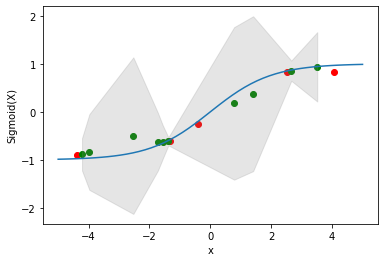

In [230]:
# plt.scatter(data["time"], sigmoid(data["time"]))
def visualize(dataX, dataY, observedX, observedY, predict, prediction, covariances):
    uncertainty = 2 * np.sqrt(covariances.diagonal())
    plt.plot(dataX, dataY) 
    plt.scatter(observedX, observedY, c="red") 
    plt.scatter(predict, prediction, c="green") 
    # plt.errorbar(predict, prediction, yerr=uncertainty, c="green", capsize=1)
    # print(predict, prediction)
    plt.fill_between(predict, prediction - uncertainty, prediction + uncertainty, color='gray', alpha=0.2)
    plt.xlabel("x") 
    plt.ylabel("Sigmoid(X)") 
    
    return plt.show() 

visualize(x_, gtruth, observed["time"], observed["values"], unobserved, predictions, covariances)

Can we do better? Yes, we can by changing the sigma parameter of the kernel. If you've read the recommended resources from above you should know that it controls how much the kernel can vary. Increasing it effectively decreases the variability outside of the sampled values. Now, there are parts which are uncertain because we haven't sampled there but one could say this seems more reasonable.

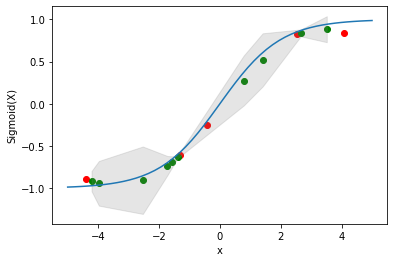

In [237]:
covXX, covXX_, covX_X_ = process_cov_matrices(observed["time"], unobserved, create_RBF_kernel(2))
predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
visualize(x_, gtruth, observed["time"], observed["values"], unobserved, predictions, covariances)

Now I want to sample a bit more and generate more points to create a fair approximation of the original function. The result seems pretty good. However, the function is still way to irregular. Next, let's try and change noise term.

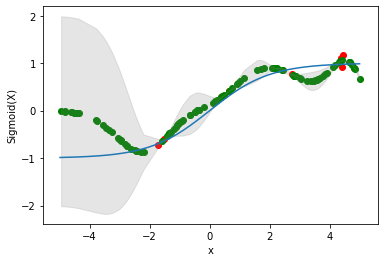

In [241]:
def run_experiment(sample_size, prediction_size, data_size=1000, dashes=False, sigma_scaler=1, noise_term=0):
    data = generate_data(data_size, sigmoid)
    sorted_time_points = sigmoid(data["time"])
    observed = data.sample(sample_size).sort_values(by="time")
    unobserved = data["time"].sample(prediction_size).sort_values()
    covXX, covXX_, covX_X_ = process_cov_matrices(observed["time"], unobserved, create_RBF_kernel(sigma_scaler), noise_term)
    predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
    visualize(data["time"], sigmoid(data["time"]), observed["time"], observed["values"], unobserved, predictions, covariances)
    
    plt.show() 
run_experiment(10, 100, sigma_scaler=1)

Now, that looks more like a proper approximation! Obviously there's still much left to desire in points that aren't sampled (especially in the beginning and the end) but the function looks a lot more smooth now.

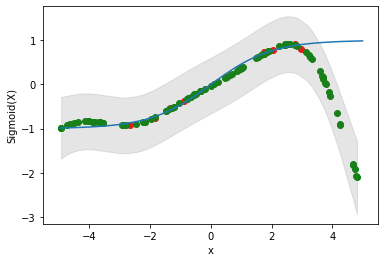

In [244]:
run_experiment(10,100, sigma_scaler=2 ,noise_term=.1)

# Prediction with 2-dimensional X and 1-dimensional Y

I wanted to show that this also works for multi dimensional X. The plot shows the function to be predicted in blue and the points that are sampled in red. The function itself is way more complex this time amd also unstandardized. 

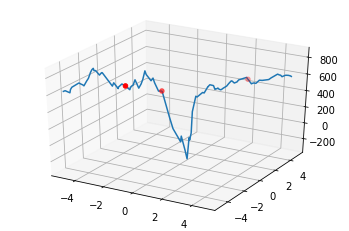

In [245]:
data_multiple_x = generate_data_multiple_x(100, [lambda x: x*25, lambda x: np.sin(1/x)*25])
observed2 = data_multiple_x.sample(3).sort_values(by=["time_0","time_1"])
unobserved2 = data_multiple_x.sample(2)[["time_0","time_1"]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_multiple_x["time_0"], data_multiple_x["time_1"], data_multiple_x["values"])
ax.scatter(observed2["time_0"], observed2["time_1"], observed2["values"], c="red")

These are methods for visualisation and prediction according to predefined functions.

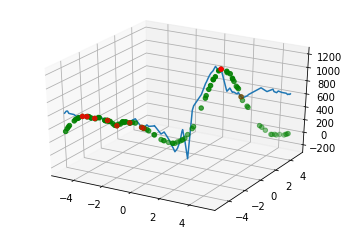

In [263]:
def visualize_3d(dataX, dataY, dataZ, observedX, observedY, observedZ, predictX, predictY, prediction, uncertainty):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(dataX, dataY, dataZ)
    ax.scatter(observedX, observedY, observedZ, c="red")
    ax.scatter(predictX, predictY, prediction, c="green") 
    # ax.errorbar(predictX, predictY, prediction, yerr=uncertainty.diagonal()*50, c="green", capsize=1)
    return ax

def run_experiment_3d(sample_size, prediction_size, data_size=1000, dashes=False, sigma_scaler=1, noise_term=0):
    data = generate_data_multiple_x(100, [lambda x: x*25, lambda x: np.sin(1/x)*25])
    observed = data.sample(sample_size).sort_values(by=["time_0","time_1"])
    unobserved = data[["time_0","time_1"]].sample(prediction_size)#.sort_values()
    covXX, covXX_, covX_X_ = process_cov_matrices(observed[["time_0","time_1"]].values, unobserved.values, create_RBF_kernel(sigma_scaler), noise_term)
    predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
    visualize_3d(data["time_0"], data["time_1"], data["values"], observed["time_0"],observed["time_1"], observed["values"], unobserved["time_0"], unobserved["time_1"], predictions, covariances)

run_experiment_3d(10,100)

# Prediction with 2-dimensional X and 1-dimensional Y - Gaussian shape
This time we are trying to learn a Gaussian probability distribution. In the same way we did it in the previous example.

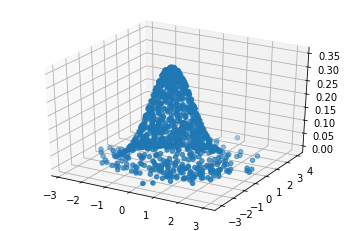

In [260]:
num = 1000

data_multiple_x = generate_data_multivariat_gaussian(num)
observed2 = data_multiple_x.sample(3).sort_values(by=["time_0","time_1"])
unobserved2 = data_multiple_x.sample(2)[["time_0","time_1"]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_multiple_x["time_0"], data_multiple_x["time_1"], data_multiple_x["values"])
ax.scatter(observed2["time_0"], observed2["time_1"], observed2["values"], c="red", marker="x", s=50, depthshade=False)

For our purposes we have to slightly modify the visualisation and experimentation function to fit our case. But in essence they do mostly the same as before. The visualizatiuon shows the ground truth in blue, observations in red and predictions in green.

This visualisation shows the true power of GPs. Why? - Because we can reconstruct a fairly good approximation (green) of the ground truth distribution with only a small number (red) of samples.

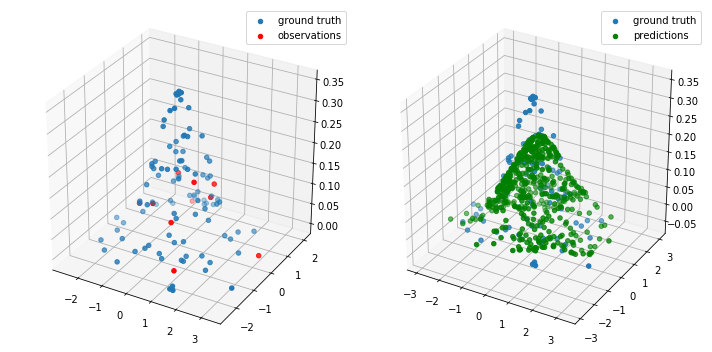

In [266]:
def visualize_multivariat_gaussian(dataX, dataY, dataZ, observedX, observedY, observedZ, predictX, predictY, prediction, uncertainty):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(dataX[::10], dataY[::10], dataZ[::10],  label="ground truth")
    ax.scatter(observedX, observedY, observedZ, c="red", label="observations")
    ax.legend()
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(dataX[::10], dataY[::10], dataZ[::10],  label="ground truth")
    ax.scatter(predictX, predictY, prediction, c="green", label="predictions") 
    ax.legend()
    plt.tight_layout()
    return ax

def run_experiment_multivariat_gaussian(sample_size, prediction_size, data_size=1000, dashes=False, sigma_scaler=1, noise_term=0):
    data = generate_data_multivariat_gaussian(data_size)
    observed = data.sample(sample_size).sort_values(by=["time_0","time_1"])
    unobserved = data[["time_0","time_1"]].sample(prediction_size)#.sort_values()
    covXX, covXX_, covX_X_ = process_cov_matrices(observed[["time_0","time_1"]].values, unobserved.values, create_RBF_kernel(sigma_scaler), noise_term)
    predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
    visualize_multivariat_gaussian(data["time_0"], data["time_1"], data["values"], observed["time_0"],observed["time_1"], observed["values"], unobserved["time_0"], unobserved["time_1"], predictions, covariances)

run_experiment_multivariat_gaussian(10,500)

That concludes our venture into GPs. In Part 2, I am going to attempt the prediction of two functions based on one set of samples.